In [1]:
# Import libraries needed from pyspark
from pyspark import SparkConf
from pyspark import SparkContext # Spark
from pyspark.sql import SparkSession # Spark SQL
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, DoubleType, TimestampType, DateType
from pyspark.sql.functions import col, sum, round, split
from pyspark.sql.functions import udf, max
from pyspark.sql.functions import current_date, to_date, datediff, floor, year
from pyspark.sql import functions as F
from pyspark.sql.functions import count, mean, stddev, min, max, expr, desc
from matplotlib import pyplot as plt
from pyspark.sql.functions import isnan, when
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.linalg import Vectors
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

In [2]:
# TODO: Create Spark Configuration Object
app_name = "Aus Cancer Analysis"
master = "local[*]"
spark_conf = SparkConf().setMaster(master).setAppName(app_name)
# Create SparkSession
spark = SparkSession.builder.config(conf=spark_conf).getOrCreate()
sc = spark.sparkContext
sc.setLogLevel('ERROR')
print('Spark Session created!')

Spark Session created!


In [3]:
cancer_schema = StructType([
    StructField("Patient_ID", StringType(), True),
    StructField("State", StringType(), True), 
    StructField("Gender", StringType(), True), 
    StructField("Age", IntegerType(), True),
    StructField("Cancer_Type", StringType(), True),
    StructField("Diagnosis_Year", IntegerType(), True),
    StructField("Stage", StringType(), True),
    StructField("Tumor_Size_cm", DoubleType(), True),
    StructField("Metastasis", IntegerType(), True),
    StructField("Smoker", IntegerType(), True),
    StructField("Alcohol_Consumption", StringType(), True),
    StructField("Physical_Activity_Level", StringType(), True),
    StructField("BMI", DoubleType(), True),
    StructField("Family_History", IntegerType(), True),
    StructField("Radiation_Therapy", IntegerType(), True),
    StructField("Chemotherapy",StringType(), True),
    StructField("Surgery", IntegerType(), True),
    StructField("Survival_Years", DoubleType(), True),
    StructField("Alive", IntegerType(), True),
    StructField("Income_Level", StringType(), True),
    StructField("Education_Level", StringType(), True),
    StructField("Marital_Status", StringType(), True),
    StructField("Occupation", StringType(), True),
    StructField("Urban_Rural", StringType(), True),
    StructField("Insurance_Covered", StringType(), True)
])

In [4]:
# Create a simple DataFrame
df = spark.read.csv("cancer_rates_australia.csv", header=True, schema=cancer_schema)

In [5]:
df.printSchema()

root
 |-- Patient_ID: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Cancer_Type: string (nullable = true)
 |-- Diagnosis_Year: integer (nullable = true)
 |-- Stage: string (nullable = true)
 |-- Tumor_Size_cm: double (nullable = true)
 |-- Metastasis: integer (nullable = true)
 |-- Smoker: integer (nullable = true)
 |-- Alcohol_Consumption: string (nullable = true)
 |-- Physical_Activity_Level: string (nullable = true)
 |-- BMI: double (nullable = true)
 |-- Family_History: integer (nullable = true)
 |-- Radiation_Therapy: integer (nullable = true)
 |-- Chemotherapy: string (nullable = true)
 |-- Surgery: integer (nullable = true)
 |-- Survival_Years: double (nullable = true)
 |-- Alive: integer (nullable = true)
 |-- Income_Level: string (nullable = true)
 |-- Education_Level: string (nullable = true)
 |-- Marital_Status: string (nullable = true)
 |-- Occupation: string (nullable = true)
 |-

In [6]:
# Show initial rows
print("\nInitial Data Sample:")
df.show(2, truncate=False)


Initial Data Sample:
+----------+----------------------------+------+---+-----------+--------------+-----+-------------+----------+------+-------------------+-----------------------+----+--------------+-----------------+------------+-------+--------------+-----+------------+---------------+--------------+----------+-----------+-----------------+
|Patient_ID|State                       |Gender|Age|Cancer_Type|Diagnosis_Year|Stage|Tumor_Size_cm|Metastasis|Smoker|Alcohol_Consumption|Physical_Activity_Level|BMI |Family_History|Radiation_Therapy|Chemotherapy|Surgery|Survival_Years|Alive|Income_Level|Education_Level|Marital_Status|Occupation|Urban_Rural|Insurance_Covered|
+----------+----------------------------+------+---+-----------+--------------+-----+-------------+----------+------+-------------------+-----------------------+----+--------------+-----------------+------------+-------+--------------+-----+------------+---------------+--------------+----------+-----------+----------------

In [7]:
print(f"\nTotal records: {df.count()}")
print(f"Total columns: {len(df.columns)}")


Total records: 3000
Total columns: 25


In [8]:
# Descriptive statistics for numerical columns
numerical_cols = ['Age', 'Tumor_Size_cm', 'BMI', 'Survival_Years']
print("\nSummary Statistics for Numerical Columns:")
df.select(numerical_cols).describe().show()


Summary Statistics for Numerical Columns:
+-------+-----------------+------------------+-----------------+-----------------+
|summary|              Age|     Tumor_Size_cm|              BMI|   Survival_Years|
+-------+-----------------+------------------+-----------------+-----------------+
|  count|             3000|              3000|             3000|             3000|
|   mean|55.03066666666667|3.5062933333333333|26.52363333333339|4.976879999999993|
| stddev|20.13228325762572|1.5119076301755165|4.071665214392625|4.877002240025778|
|    min|               20|             -1.55|             12.7|              0.0|
|    max|               89|              8.63|             41.7|             36.1|
+-------+-----------------+------------------+-----------------+-----------------+



In [9]:
categorical_cols = ['Gender', 'State', 'Cancer_Type', 'Stage', 'Metastasis', 'Smoker', 'Family_History', 'Radiation_Therapy', 'Surgery', 'Alive']
df.select(categorical_cols).describe().show()

+-------+------+--------------------+-----------+-----+-------------------+-------------------+-------------------+------------------+------------------+------------------+
|summary|Gender|               State|Cancer_Type|Stage|         Metastasis|             Smoker|     Family_History| Radiation_Therapy|           Surgery|             Alive|
+-------+------+--------------------+-----------+-----+-------------------+-------------------+-------------------+------------------+------------------+------------------+
|  count|  3000|                3000|       3000| 3000|               3000|               3000|               3000|              3000|              3000|              3000|
|   mean|  NULL|                NULL|       NULL| NULL|              0.285| 0.4036666666666667|              0.355|0.5136666666666667|             0.491|0.5993333333333334|
| stddev|  NULL|                NULL|       NULL| NULL|0.45148969827584806|0.49071392440751505|0.47859309486258755|0.4998965103524695|0

In [10]:
# Check for null or NaN values in all columns
print("\nMissing Value Counts per Column:")
missing_counts = df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns])
missing_counts.show()


Missing Value Counts per Column:
+----------+-----+------+---+-----------+--------------+-----+-------------+----------+------+-------------------+-----------------------+---+--------------+-----------------+------------+-------+--------------+-----+------------+---------------+--------------+----------+-----------+-----------------+
|Patient_ID|State|Gender|Age|Cancer_Type|Diagnosis_Year|Stage|Tumor_Size_cm|Metastasis|Smoker|Alcohol_Consumption|Physical_Activity_Level|BMI|Family_History|Radiation_Therapy|Chemotherapy|Surgery|Survival_Years|Alive|Income_Level|Education_Level|Marital_Status|Occupation|Urban_Rural|Insurance_Covered|
+----------+-----+------+---+-----------+--------------+-----+-------------+----------+------+-------------------+-----------------------+---+--------------+-----------------+------------+-------+--------------+-----+------------+---------------+--------------+----------+-----------+-----------------+
|         0|    0|     0|  0|          0|             0| 

In [11]:
# List of categorical and binary features for frequency counts
categorical_features = [
    'State', 'Gender', 'Cancer_Type', 'Diagnosis_Year', 'Stage',
    'Metastasis', 'Smoker', 'Alcohol_Consumption', 'Physical_Activity_Level',
    'Family_History', 'Radiation_Therapy', 'Chemotherapy', 'Surgery', 'Alive',
    'Income_Level', 'Education_Level', 'Marital_Status', 'Occupation',
    'Urban_Rural', 'Insurance_Covered'
]


print("\nFrequency Distributions for Categorical Features:")
for column in categorical_features:
    print(f"--- Distribution for {column} ---")
    df.groupBy(column).count().orderBy('count', ascending=False).show(truncate=False)



Frequency Distributions for Categorical Features:
--- Distribution for State ---
+----------------------------+-----+
|State                       |count|
+----------------------------+-----+
|New South Wales             |400  |
|South Australia             |386  |
|Victoria                    |377  |
|Tasmania                    |374  |
|Western Australia           |372  |
|Australian Capital Territory|368  |
|Queensland                  |363  |
|Northern Territory          |360  |
+----------------------------+-----+

--- Distribution for Gender ---
+------+-----+
|Gender|count|
+------+-----+
|Male  |1501 |
|Female|1499 |
+------+-----+

--- Distribution for Cancer_Type ---
+-----------+-----+
|Cancer_Type|count|
+-----------+-----+
|Lung       |329  |
|Ovarian    |329  |
|Bladder    |326  |
|Leukemia   |307  |
|Breast     |307  |
|Prostate   |298  |
|Pancreatic |292  |
|Colorectal |282  |
|Liver      |269  |
|Melanoma   |261  |
+-----------+-----+

--- Distribution for Diagnosis_Y

In [12]:
# Calculate correlations between key numerical features
print("\nCorrelation Matrix (Numerical Features):")
# Spark calculates correlation pairwise
for col1 in numerical_cols:
    for col2 in numerical_cols:
        if col1 != col2:
            correlation = df.stat.corr(col1, col2)
            print(f"Correlation between {col1} and {col2}: {correlation}")


Correlation Matrix (Numerical Features):
Correlation between Age and Tumor_Size_cm: -0.0012628605406139702
Correlation between Age and BMI: 0.007309921893929218
Correlation between Age and Survival_Years: 0.019501725222049068
Correlation between Tumor_Size_cm and Age: -0.0012628605406139709
Correlation between Tumor_Size_cm and BMI: 0.008461682751043115
Correlation between Tumor_Size_cm and Survival_Years: -0.007668753933524458
Correlation between BMI and Age: 0.007309921893929198
Correlation between BMI and Tumor_Size_cm: 0.008461682751043122
Correlation between BMI and Survival_Years: -0.007123468229033229
Correlation between Survival_Years and Age: 0.01950172522204907
Correlation between Survival_Years and Tumor_Size_cm: -0.007668753933524463
Correlation between Survival_Years and BMI: -0.007123468229033221


In [13]:
# Take a sample (e.g., 10% of the data) and convert to Pandas for visualization
sample_df = df.sample(withReplacement=False, fraction=0.1, seed=42).toPandas()

Generating histograms for numerical features...


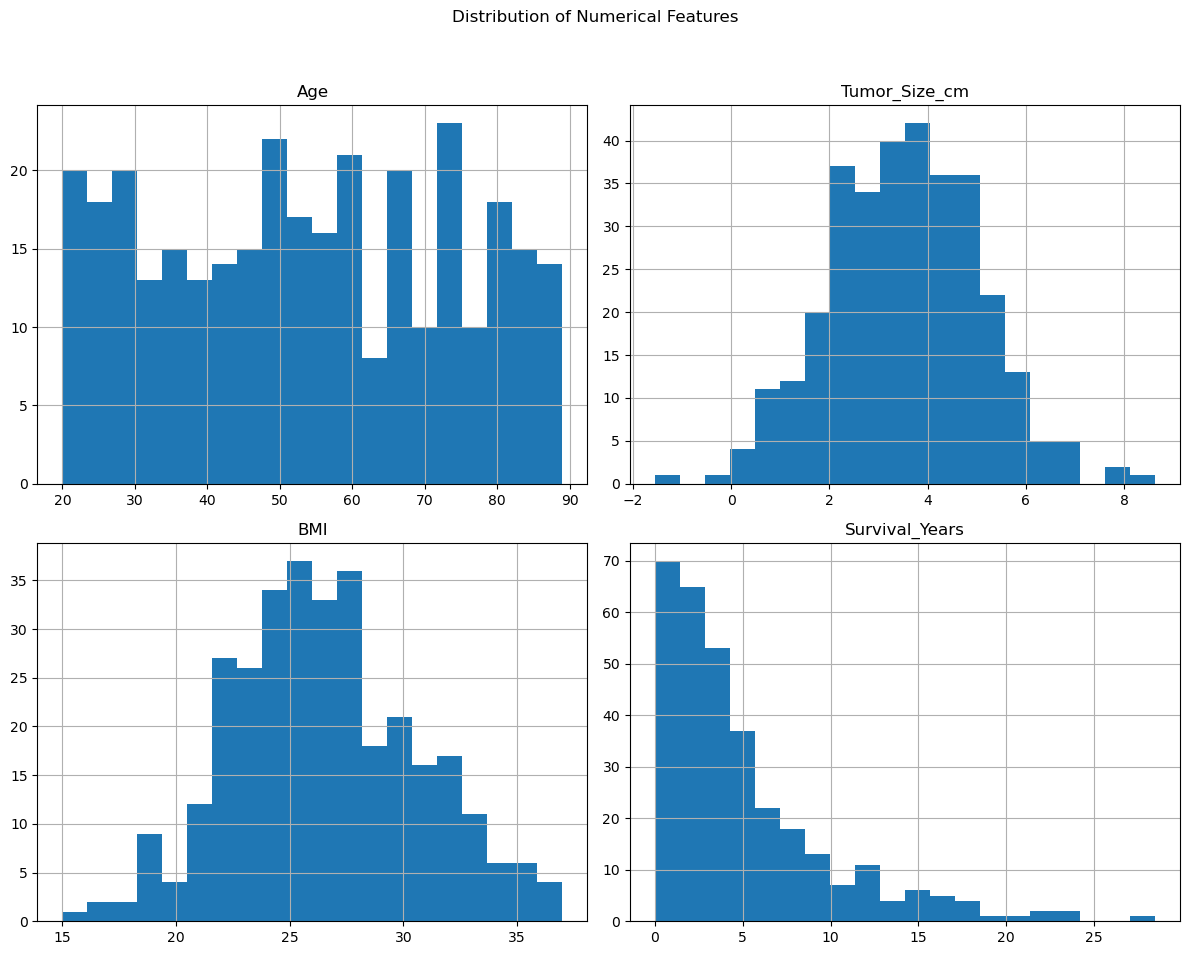

In [14]:
# --- Histograms for Numerical Distributions ---
print("Generating histograms for numerical features...")
sample_df[numerical_cols].hist(bins=20, figsize=(12, 10))
plt.suptitle("Distribution of Numerical Features")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Generating box plots for outlier detection...


/opt/conda/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.11/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/opt/conda/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.11/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future ve

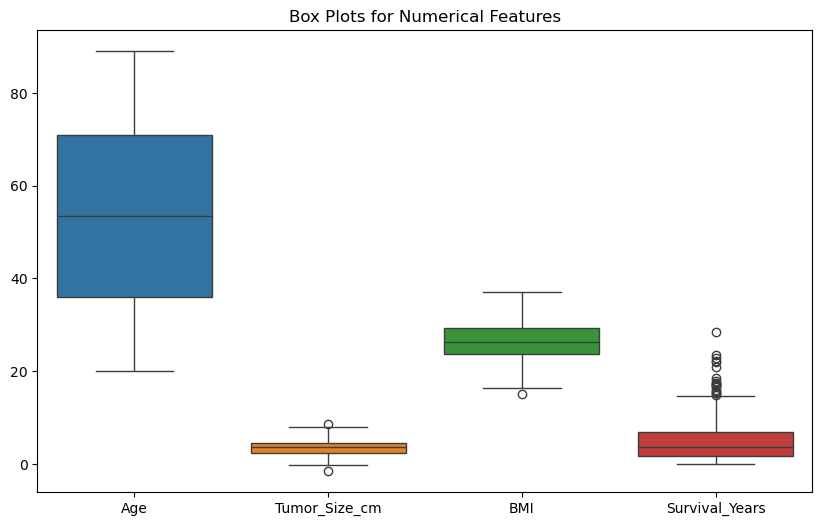

In [15]:
# --- Box Plots for Outlier Detection ---
print("Generating box plots for outlier detection...")
plt.figure(figsize=(10, 6))
sns.boxplot(data=sample_df[numerical_cols])
plt.title("Box Plots for Numerical Features")
plt.show()

Analyzing target variable 'Alive'...


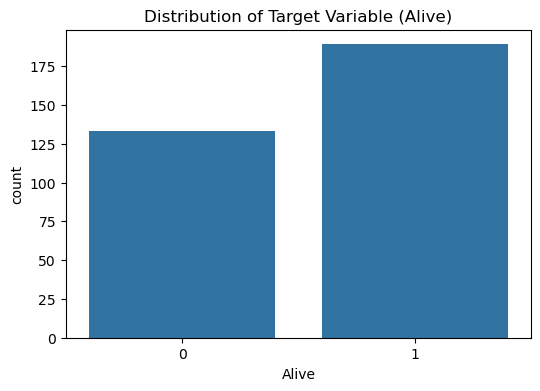

In [16]:
# --- Target Variable Analysis (Assuming 'Alive' is the target) ---
print("Analyzing target variable 'Alive'...")
plt.figure(figsize=(6, 4))
sns.countplot(x='Alive', data=sample_df)
plt.title("Distribution of Target Variable (Alive)")
plt.show()

Generating Age distribution by Survival Status...


/opt/conda/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


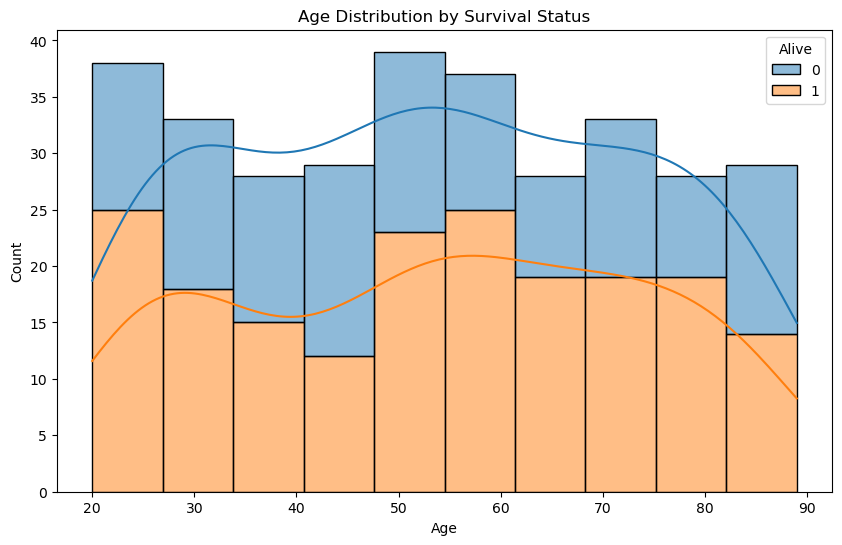

In [17]:
# --- Relationship between Key Features and Target ---
# Example: Age distribution by survival status
print("Generating Age distribution by Survival Status...")
plt.figure(figsize=(10, 6))
sns.histplot(data=sample_df, x='Age', hue='Alive', multiple='stack', kde=True)
plt.title("Age Distribution by Survival Status")
plt.show()

Generating Tumor Size vs. Survival Years scatter plot...


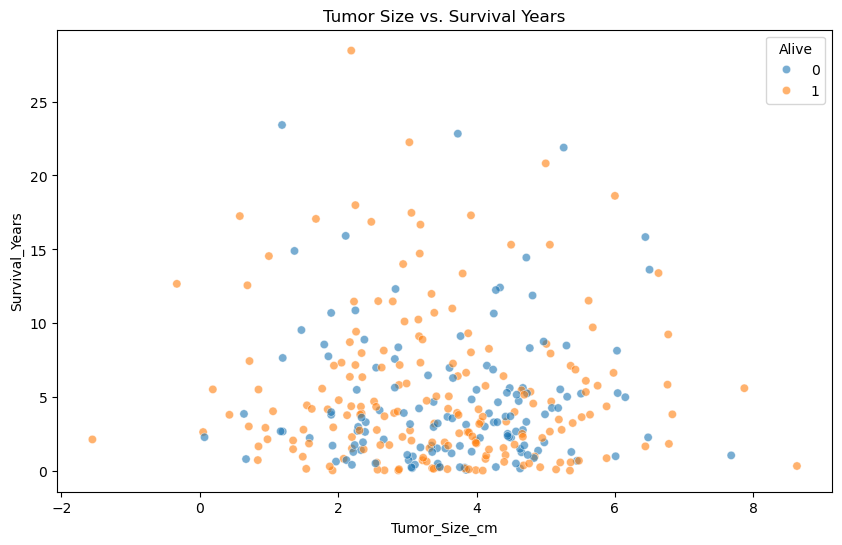

In [18]:
# Example: Tumor Size vs. Survival Years
print("Generating Tumor Size vs. Survival Years scatter plot...")
plt.figure(figsize=(10, 6))
sns.scatterplot(data=sample_df, x='Tumor_Size_cm', y='Survival_Years', hue='Alive', alpha=0.6)
plt.title("Tumor Size vs. Survival Years")
plt.show()

/tmp/ipykernel_8467/2890249876.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=survival_rate_sorted.index, y=survival_rate_sorted.values, palette="viridis")
/opt/conda/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarnin

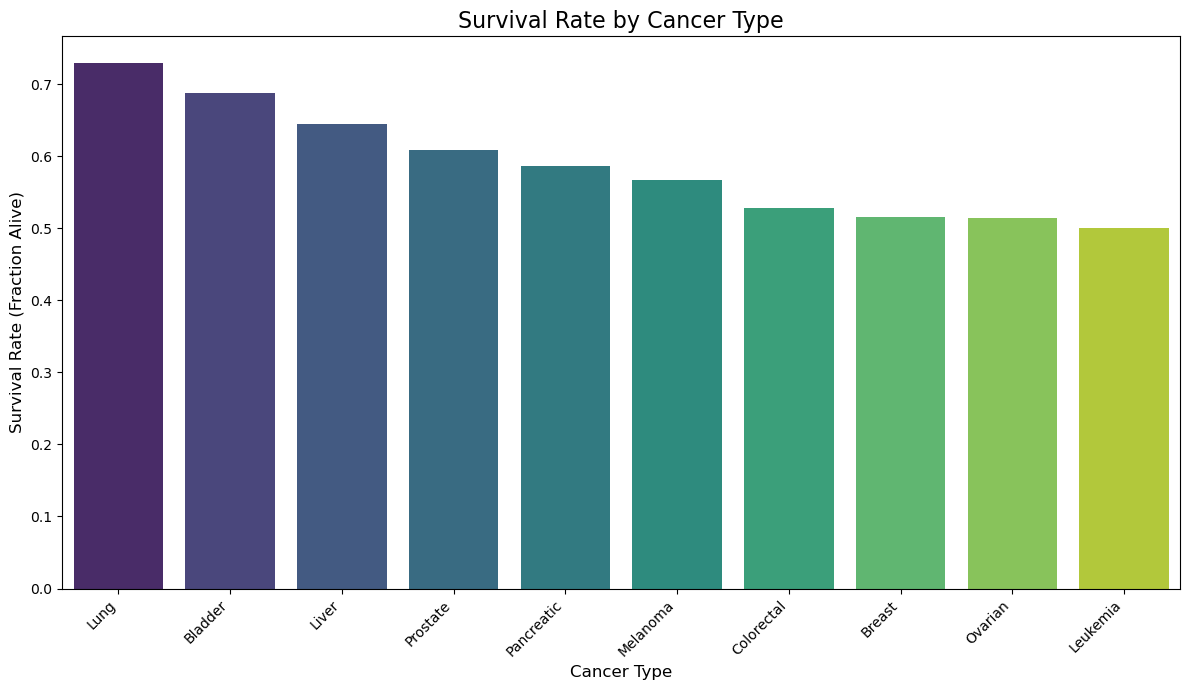

In [19]:
# Calculate survival rate for each cancer type
survival_rate = sample_df.groupby('Cancer_Type')['Alive'].value_counts(normalize=True).unstack()
survival_rate_sorted = survival_rate[1].sort_values(ascending=False)

# Plotting the survival rate
plt.figure(figsize=(12, 7))
sns.barplot(x=survival_rate_sorted.index, y=survival_rate_sorted.values, palette="viridis")
plt.title('Survival Rate by Cancer Type', fontsize=16)
plt.ylabel('Survival Rate (Fraction Alive)', fontsize=12)
plt.xlabel('Cancer Type', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

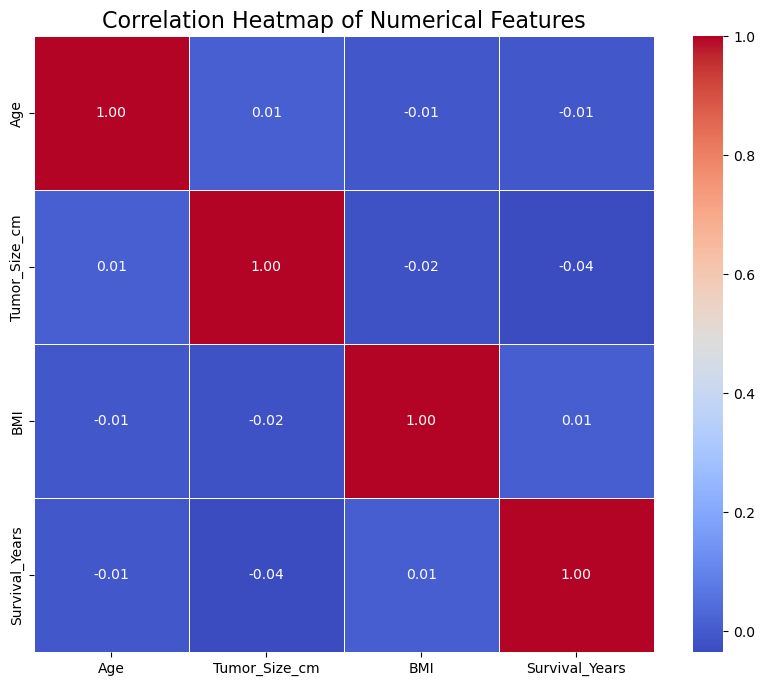

In [20]:
# Select only numerical columns for the correlation matrix
numerical_data = sample_df[['Age', 'Tumor_Size_cm', 'BMI', 'Survival_Years']]

# Calculate the correlation matrix
corr_matrix = numerical_data.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Heatmap of Numerical Features', fontsize=16)
plt.show()

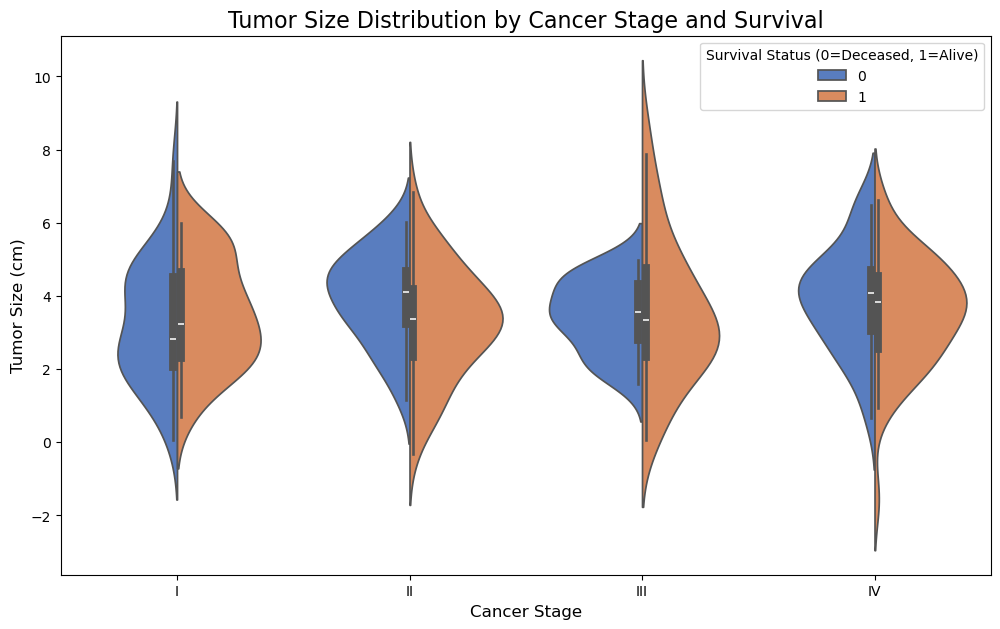

In [21]:
stage_order = sorted(sample_df['Stage'].unique())

plt.figure(figsize=(12, 7))
sns.violinplot(data=sample_df, x='Stage', y='Tumor_Size_cm', hue='Alive', order=stage_order, split=True, palette='muted')
plt.title('Tumor Size Distribution by Cancer Stage and Survival', fontsize=16)
plt.xlabel('Cancer Stage', fontsize=12)
plt.ylabel('Tumor Size (cm)', fontsize=12)
plt.legend(title='Survival Status (0=Deceased, 1=Alive)')
plt.show()

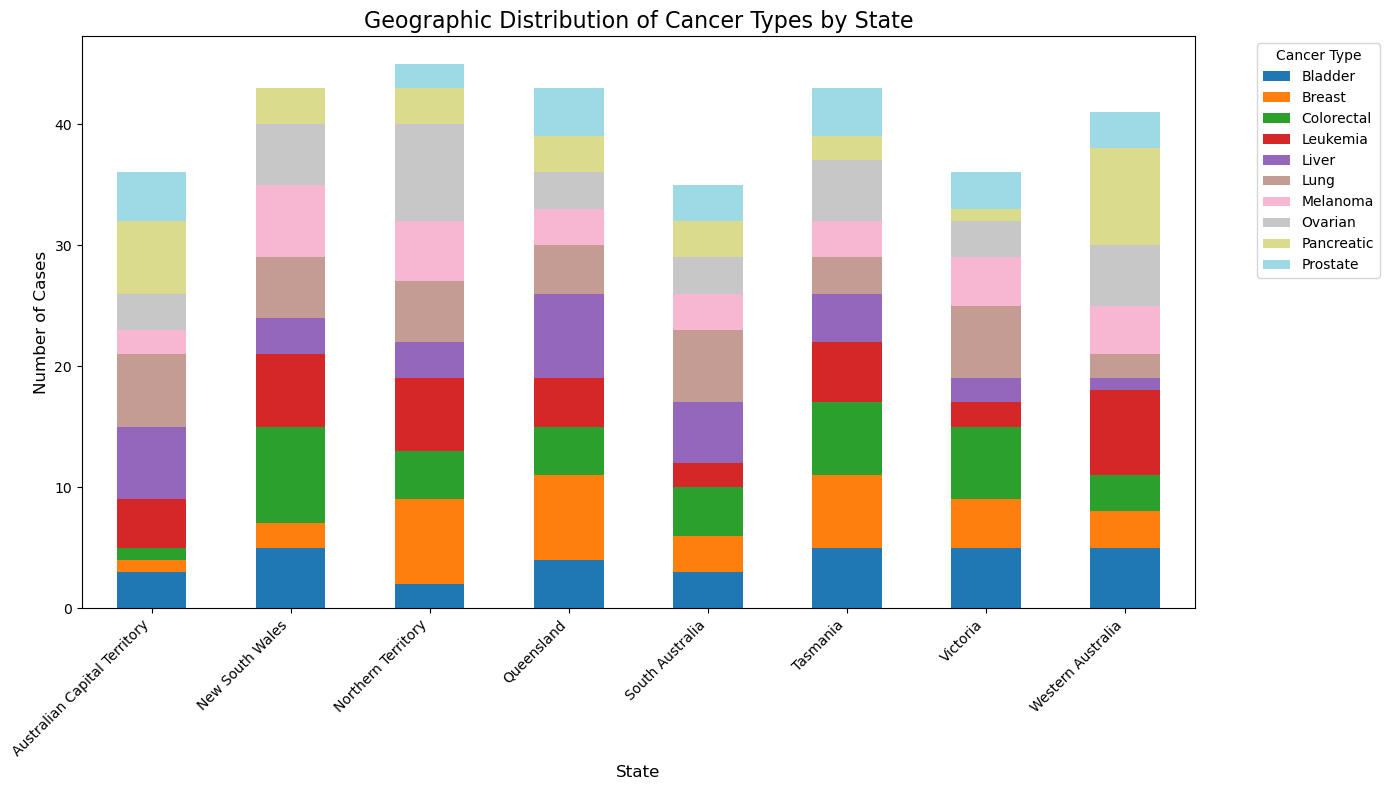

In [22]:
# Create a cross-tabulation of State and Cancer_Type
state_cancer_crosstab = pd.crosstab(sample_df['State'], sample_df['Cancer_Type'])

state_cancer_crosstab.plot(kind='bar', stacked=True, figsize=(14, 8), colormap='tab20')
plt.title('Geographic Distribution of Cancer Types by State', fontsize=16)
plt.xlabel('State', fontsize=12)
plt.ylabel('Number of Cases', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Cancer Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

/opt/conda/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.11/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/opt/conda/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tu

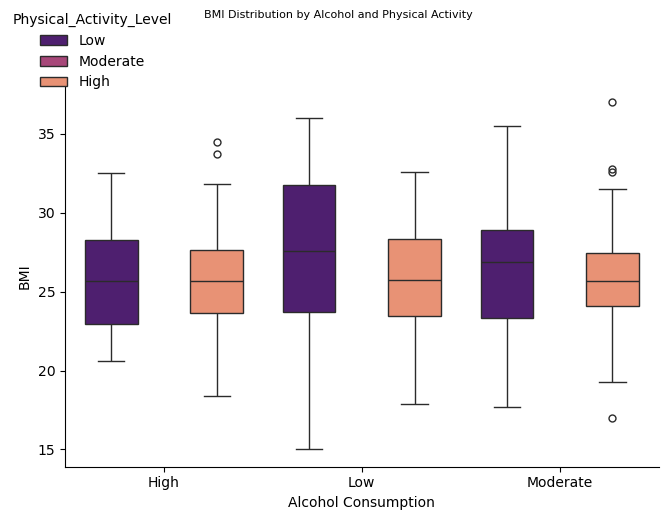

In [23]:
activity_order = ['Low', 'Moderate', 'High']

g = sns.catplot(data=sample_df, x='Alcohol_Consumption', y='BMI',
                hue='Physical_Activity_Level', hue_order=activity_order,
                kind='box', palette='magma')

sns.move_legend(g, "upper left")

# Set labels and a main title for the plot
g.set_axis_labels("Alcohol Consumption", "BMI")
g.fig.suptitle('BMI Distribution by Alcohol and Physical Activity', y=1.03, fontsize=8)

plt.tight_layout(rect=[0, 0, 1, 0.96])

plt.show()

In [24]:
#Question to Answer: Is the average tumor size significantly different between smokers and non-smokers?

In [25]:
from scipy.stats import ttest_ind

# Separate the data into two groups: smokers and non-smokers
# Drop missing values for a clean comparison
smokers_bmi = sample_df[sample_df['Smoker'] == 1]['BMI'].dropna()
non_smokers_bmi = sample_df[sample_df['Smoker'] == 0]['BMI'].dropna()

# Perform the independent t-test
t_stat, p_value = ttest_ind(smokers_bmi, non_smokers_bmi)

print(f"T-test for BMI between Smokers and Non-Smokers:")
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")

# Interpret the result
if p_value < 0.05:
    print("\nThe difference is statistically significant (p < 0.05).")
else:
    print("\nThe difference is not statistically significant (p >= 0.05).")

T-test for BMI between Smokers and Non-Smokers:
T-statistic: -0.3332
P-value: 0.7392

The difference is not statistically significant (p >= 0.05).


In [26]:
# Has the average survival duration changed from year to year?

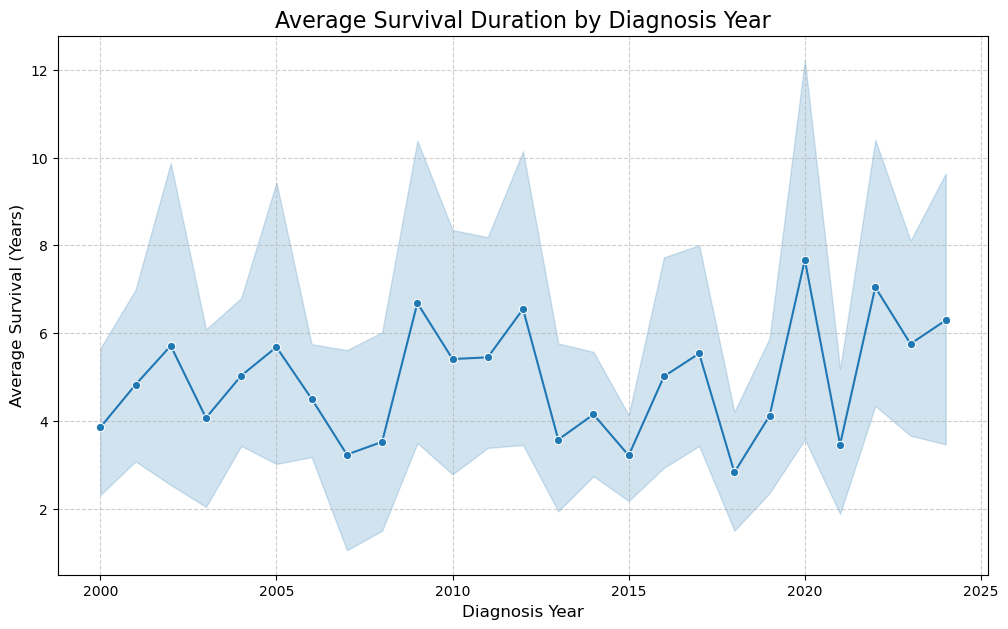

In [27]:
plt.figure(figsize=(12, 7))

# Use seaborn's lineplot to automatically calculate the mean and confidence interval
sns.lineplot(data=sample_df, x='Diagnosis_Year', y='Survival_Years', marker='o')

plt.title('Average Survival Duration by Diagnosis Year', fontsize=16)
plt.xlabel('Diagnosis Year', fontsize=12)
plt.ylabel('Average Survival (Years)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [28]:
spark.stop()
print("SparkSession stopped.")

SparkSession stopped.
